# DSE200x: Final Project
# Steve Hall: December 2019
## Forecasting Interest Rates using Machine Learning Techniques

## Import Libraries and Data 

In [57]:
# libraries
import pandas as pd
import numpy as np 
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
%matplotlib inline

In [58]:
# load database of market prices into pandas
raw = pd.read_csv('./data/db_MarketPredictors.csv', sep=',')

In [60]:
print(raw.shape)
raw.head()

(7811, 197)


,Day,Date,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,...,BCAUOAS Index,BCM5OAS Index,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BAGEOAS Index,BNA1OAS Index,BCM8OAS Index
0,2,12/9/2019,3138.53,999.76,2015.46,8372.490,179.27,954.5700,641.06,436.85,...,9.44,0.35,0.48,0.37,0.42,0.29,0.71,0.49,0.86,0.86
1,6,12/6/2019,3145.91,1002.13,2021.98,8397.367,179.48,953.2015,639.92,437.91,...,9.44,0.35,0.48,0.37,0.42,0.29,0.71,0.49,0.86,0.86
2,5,12/5/2019,3117.43,988.01,2003.00,8308.396,178.36,945.5638,637.57,429.34,...,9.78,0.36,0.51,0.37,0.42,0.30,0.71,0.49,0.86,0.86
3,4,12/4/2019,3112.76,985.29,1999.53,8296.529,177.67,947.6669,638.77,431.48,...,9.79,0.36,0.50,0.37,0.42,0.30,0.71,0.49,0.85,0.85
4,3,12/3/2019,3093.20,977.51,1983.92,8254.737,176.54,943.8462,634.57,424.81,...,9.99,0.37,0.51,0.37,0.42,0.30,0.70,0.49,0.85,0.85


I have downloaded 195 series of market price data. The futures data is adjusted for the roll, adjusting the ratio between the prompt and next contract 5 days prior to expiration.
<br>
<br>
*Data source: Bloomberg; daily from 1/1/1990 through 12/9/2019.* 

In [61]:
raw['Date'] =pd.to_datetime(raw.Date)
raw = raw.sort_values('Date')

In [62]:
# let's add year and month-year to the dataframe
raw['Year'] = pd.DatetimeIndex(raw['Date']).year
raw['Year_MM'] = pd.to_datetime(raw['Date']).dt.to_period('M')
dates = raw['Date']
raw.head()

,Day,Date,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,...,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BAGEOAS Index,BNA1OAS Index,BCM8OAS Index,Year,Year_MM
7810,2,1990-01-01,353.40,NaN,NaN,223.835,99.89,71.2032,62.33,91.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,1990-01
7809,3,1990-01-02,359.69,NaN,NaN,227.725,101.27,73.3261,62.86,92.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,1990-01
7808,4,1990-01-03,358.76,NaN,NaN,226.100,100.47,73.1502,62.72,90.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,1990-01
7807,5,1990-01-04,355.67,NaN,NaN,224.715,97.78,72.8757,61.89,89.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,1990-01
7806,6,1990-01-05,352.20,NaN,NaN,223.140,95.64,72.3403,61.38,88.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990,1990-01


In [63]:
# remove day and date from the dataframe
raw_prices = raw.iloc[:,2:-2]
raw_prices.head()

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,BCAUOAS Index,BCM5OAS Index,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BAGEOAS Index,BNA1OAS Index,BCM8OAS Index
7810,353.40,NaN,NaN,223.835,99.89,71.2032,62.33,91.62,76.14,72.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7809,359.69,NaN,NaN,227.725,101.27,73.3261,62.86,92.03,77.35,73.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7808,358.76,NaN,NaN,226.100,100.47,73.1502,62.72,90.74,77.48,74.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7807,355.67,NaN,NaN,224.715,97.78,72.8757,61.89,89.68,76.97,73.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7806,352.20,NaN,NaN,223.140,95.64,72.3403,61.38,88.79,76.24,72.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Exploration

In [64]:
# create a df of statistics of the market prices
stats_prices = raw_prices.describe().transpose()

In [65]:
# now let's calculate daily price returns for each series
raw_rets = raw_prices.pct_change()
# add back the unique months-years
raw_rets['Year_MM'] = raw['Year_MM'] 
raw_rets.head()

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,BCM5OAS Index,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BAGEOAS Index,BNA1OAS Index,BCM8OAS Index,Year_MM
7810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-01
7809,0.017799,NaN,NaN,0.017379,0.013815,0.029815,0.008503,0.004475,0.015892,0.014746,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-01
7808,-0.002586,NaN,NaN,-0.007136,-0.007900,-0.002399,-0.002227,-0.014017,0.001681,0.007470,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-01
7807,-0.008613,NaN,NaN,-0.006126,-0.026774,-0.003753,-0.013233,-0.011682,-0.006582,-0.006740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-01
7806,-0.009756,NaN,NaN,-0.007009,-0.021886,-0.007347,-0.008240,-0.009924,-0.009484,-0.014658,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-01


In [66]:
# create a df of statistics of the market prices
stats_rets = raw_rets.describe().transpose()

In [67]:
# average daily returns by month
monthly_rets = raw_rets.groupby(['Year_MM']).sum()
monthly_rets.head()

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,BCAUOAS Index,BCM5OAS Index,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BAGEOAS Index,BNA1OAS Index,BCM8OAS Index
Year_MM,,,,,,,,,,,,,,,,,,,,,
1990-01,-0.069845,0.0,0.0,-0.100755,-0.135176,-0.067095,-0.099511,-0.036108,-0.110280,-0.066651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-02,0.009007,0.0,0.0,0.029817,-0.004466,0.018933,-0.015465,0.018433,0.032155,-0.027902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-03,0.024480,0.0,0.0,0.025821,0.049772,0.029731,0.056362,0.003447,-0.031671,0.033875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-04,-0.026771,0.0,0.0,-0.034203,-0.036512,-0.037562,0.012241,-0.038407,-0.044783,0.003263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-05,0.088675,0.0,0.0,0.138619,0.083135,0.102705,0.098296,0.060451,0.115542,0.121566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# number of months
len(monthly_rets)

360

In [69]:
# instead of summing daily returns we could calculate rolling 21 day returns (roughly 21 days/ month)
# let's create a function
def rolling_pct_rets(df, periods):
    rets = (df.shift(periods=periods, fill_value=0)/ df) - 1
    rets = rets[:periods]
    return rets

In [74]:
# calculate rolling pct changes for all variables except credit spreads
prices_ex_spreads = raw_prices.iloc[:,:100]
prices_ex_spreads.head()

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,NG1 Comdty,XB1 Comdty,GC1 Comdty,SI1 Comdty,KC1 Comdty,SB1 Comdty,C 1 Comdty,W 1 Comdty,CT1 Comdty,LH1 Comdty
7810,353.40,NaN,NaN,223.835,99.89,71.2032,62.33,91.62,76.14,72.56,...,NaN,NaN,667.24,10.334,455.95,12.81,1716.8750,5064.0000,238.07,189.313
7809,359.69,NaN,NaN,227.725,101.27,73.3261,62.86,92.03,77.35,73.63,...,NaN,NaN,662.14,10.295,461.62,12.68,1702.5625,5057.8125,235.55,189.022
7808,358.76,NaN,NaN,226.100,100.47,73.1502,62.72,90.74,77.48,74.18,...,NaN,NaN,652.75,10.230,468.44,13.84,1707.9375,5073.2500,238.17,189.895
7807,355.67,NaN,NaN,224.715,97.78,72.8757,61.89,89.68,76.97,73.68,...,NaN,NaN,660.00,10.455,472.62,13.79,1706.1250,5064.0000,232.14,196.009
7806,352.20,NaN,NaN,223.140,95.64,72.3403,61.38,88.79,76.24,72.60,...,NaN,NaN,672.68,10.553,465.06,13.78,1702.5625,5070.1875,228.55,198.143


In [93]:
lookback = 21
monthly_rets2 = rolling_pct_rets(prices_ex_spreads, -lookback)
monthly_rets2.shape

(7790, 100)

(7790, 25)

In [95]:
monthly_rets2 = pd.concat((monthly_rets2, spreads), axis=1)
monthly_rets2.shape

(7790, 125)

In [96]:
# append dates to monthly_rets
Day = raw['Date'][:-lookback]
monthly_rets2 = pd.concat((monthly_rets2, Day), axis=1)
monthly_rets2 = monthly_rets2.sort_values('Date')

In [97]:
monthly_rets2.tail(22)

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,BCM5OAS Index,BCM3OAS Index,LUABOAS Index.1,LAATOAS Index,LACCOAS Index,LUCMOAS Index.1,BAGEOAS Index,BNA1OAS Index,BCM8OAS Index,Date
42,0.052738,0.076441,0.060621,0.066602,0.052543,0.019564,-0.001792,0.056905,0.090386,0.065839,...,0.43,0.56,0.40,0.45,0.33,0.73,0.55,0.85,0.86,2019-10-10
41,0.039303,0.053463,0.040640,0.050745,0.037620,0.005261,-0.002770,0.036469,0.073785,0.052994,...,0.41,0.52,0.41,0.46,0.34,0.74,0.55,0.86,0.88,2019-10-11
40,0.042375,0.057178,0.042933,0.053741,0.042818,0.005099,0.003828,0.031599,0.072892,0.059464,...,0.41,0.52,0.41,0.46,0.34,0.74,0.55,0.86,0.88,2019-10-14
39,0.032834,0.039583,0.032297,0.039905,0.030532,-0.008281,0.016502,0.022296,0.052728,0.042269,...,0.42,0.53,0.43,0.48,0.36,0.74,0.56,0.86,0.88,2019-10-15
38,0.035770,0.034739,0.035924,0.042628,0.032126,-0.008856,0.014294,0.034744,0.056256,0.042736,...,0.44,0.54,0.43,0.48,0.37,0.73,0.55,0.85,0.86,2019-10-16
37,0.040865,0.028574,0.031960,0.047012,0.032853,-0.010561,0.011233,0.041280,0.059845,0.057773,...,0.44,0.55,0.43,0.48,0.37,0.73,0.55,0.85,0.86,2019-10-17
36,0.045486,0.029767,0.031573,0.058459,0.044815,-0.004027,0.014757,0.033043,0.058956,0.057346,...,0.44,0.56,0.43,0.47,0.36,0.73,0.55,0.85,0.87,2019-10-18
35,0.037735,0.022277,0.027566,0.050175,0.037794,-0.018294,0.008937,-0.000747,0.045742,0.065043,...,0.44,0.56,0.42,0.46,0.36,0.72,0.54,0.84,0.86,2019-10-21
34,0.037540,0.013127,0.024185,0.051956,0.038904,-0.013974,0.010501,-0.003432,0.043454,0.062296,...,0.45,0.59,0.41,0.45,0.35,0.72,0.54,0.84,0.86,2019-10-22
33,0.032957,0.005852,0.016283,0.047677,0.034909,-0.014894,0.000382,0.005305,0.038716,0.057999,...,0.44,0.58,0.41,0.45,0.35,0.71,0.53,0.84,0.85,2019-10-23


In [98]:
# Now let's compare both approaches to calculating average monthly returns
stats_Mrets = monthly_rets.describe().transpose()
stats_Mrets2 = monthly_rets2.describe().transpose()

In [99]:
ave_ret_comp = pd.concat([stats_Mrets['mean']*12, stats_Mrets2['mean']*12], axis=1) #multiply by 12 to annualize
ave_ret_comp.columns.values[0] = "Calendar"
ave_ret_comp.columns.values[1] = "Rolling"
ave_ret_comp['Diff'] = ave_ret_comp['Calendar'] - ave_ret_comp['Rolling']
ave_ret_comp.head(15)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Calendar,Rolling,Diff
AUD/USD,0.001932,0.001219,0.000713
BAGEOAS Index,0.017001,5.378266,-5.361266
BCAUOAS Index,0.049200,108.341746,-108.292546
BCBAOAS Index,0.045509,40.549811,-40.504302
BCBHOAS Index,0.034793,60.115967,-60.081174
BCM3OAS Index,NaN,6.049253,NaN
BCM5OAS Index,0.293165,6.390293,-6.097128
BCM8OAS Index,0.001983,13.244396,-13.242413
BNA1OAS Index,0.021109,21.596653,-21.575543
BTXMOAS Index,inf,10.719366,inf


You can see the average annualized monthly returns are fairly similar across indices and sectors.

## Data Preprocessing

Let's start by selecting monthly changes in interest rates. We will use the 10-year Treasury yield as our proxy. 

In [19]:
# Our label or response variable
TenYr = monthly_rets2['USGG10YR Index']
TenYr.head(22)

7810    0.071204
7809    0.061791
7808    0.054678
7807    0.064977
7806    0.067134
7805    0.070894
7804    0.066300
7803    0.051909
7802    0.030582
7801    0.036314
7800    0.025515
7799    0.021230
7798    0.026737
7797    0.012887
7796    0.030126
7795    0.043531
7794    0.030063
7793    0.020311
7792    0.015458
7791    0.000000
7790   -0.015222
7789    0.002353
Name: USGG10YR Index, dtype: float64

In [20]:
# Now we need to shift it forward 21 days since we want to predict forward changes in rates
Fwd_TenYr = TenYr.shift(periods=-21)
print(len(Fwd_TenYr))
Fwd_TenYr.head()
# note that the 22nd observation is now the first obervation (0.001647)

7790


7810    0.002353
7809    0.019002
7808    0.016647
7807    0.016490
7806    0.004695
Name: USGG10YR Index, dtype: float64

In [37]:
# Let's select a sample of the data that we want to use for model development
# I'm going to use the last 5000 days (~20 years of data)
n = 5000
select_Y = Fwd_TenYr.iloc[-n:]
print(select_Y.shape)
select_Y.tail()

(5000,)


25   NaN
24   NaN
23   NaN
22   NaN
21   NaN
Name: USGG10YR Index, dtype: float64

In [38]:
# I want to use features with at least 5000 days (20 years)
features = monthly_rets2.iloc[-n:,100:]
# append credit spreads back to monthly_rets
spreads = raw_prices.iloc[:-lookback,-25:]
spreads.shape

(5000, 180)


,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,NG6 Comdty,GC6 Comdty,SI6 Comdty,KC6 Comdty,SB6 Comdty,C 6 Comdty,W 6 Comdty,CT6 Comdty,LH6 Comdty,LH6 Comdty.1
25,0.004850,-0.011428,-0.005604,0.005369,0.014889,-0.014009,0.021145,-0.058322,0.004414,0.043553,...,-0.078189,-0.021531,-0.050565,0.134167,-0.000733,-0.028542,0.006906,-0.008366,-0.048554,-0.050745
24,0.012405,-0.004938,0.000100,0.010517,0.022091,-0.011443,0.025346,-0.047863,0.010059,0.062583,...,-0.077869,-0.006753,-0.043142,0.091794,-0.002182,-0.025451,0.002251,-0.006164,-0.051741,-0.056211
23,0.013212,0.003524,0.006356,0.013710,0.028130,-0.014210,0.018076,-0.030376,0.009672,0.056987,...,-0.061983,-0.010858,-0.038079,0.100666,0.012491,-0.026140,-0.002699,-0.004697,-0.061415,-0.062058
22,0.019684,0.014795,0.014724,0.021621,0.027714,-0.000608,0.025759,-0.026391,0.016525,0.061981,...,-0.078512,-0.005157,-0.032516,0.091134,0.022173,-0.023185,0.003618,-0.010743,-0.068125,-0.078032
21,0.015751,0.012149,0.010228,0.015928,0.027099,0.002977,0.026892,-0.018806,0.013974,0.049219,...,-0.098361,-0.002619,-0.020196,0.123406,0.031641,-0.028571,0.006453,-0.015763,-0.078118,-0.070195


In [ ]:
select_X = features.dropna(axis='columns')
print(select_X.shape)
select_X.tail()

In [39]:
# Also need to align dates with the select dataset
select_dates = monthly_rets2.iloc[-n:,-1]
print(select_dates.shape)
select_dates.tail()

(5000,)


25   2019-11-04
24   2019-11-05
23   2019-11-06
22   2019-11-07
21   2019-11-08
Name: Date, dtype: datetime64[ns]

In [40]:
# let's merge select_Y and select_X to ensure they are the same size and remove any NA
select_dataset = pd.concat((select_Y, select_X,select_dates), axis=1)
select_dataset.head()

,USGG10YR Index,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,...,GC6 Comdty,SI6 Comdty,KC6 Comdty,SB6 Comdty,C 6 Comdty,W 6 Comdty,CT6 Comdty,LH6 Comdty,LH6 Comdty.1,Date
5020,0.015598,-0.068652,-0.082180,-0.076917,-0.139867,-0.027295,-0.076526,0.067455,0.020499,-0.087815,...,-0.006271,0.008608,-0.010373,0.060565,0.036873,0.036185,-0.038903,0.013733,0.009960,2000-09-11
5019,0.010399,-0.079218,-0.088097,-0.085106,-0.154448,-0.063758,-0.102978,0.058530,0.026786,-0.094654,...,-0.012887,-0.004286,0.001445,0.048684,0.045565,0.049156,-0.021062,0.012639,0.005010,2000-09-12
5018,0.012259,-0.104471,-0.105718,-0.101957,-0.197047,-0.093268,-0.157763,0.055961,0.054114,-0.133303,...,0.007668,0.010029,-0.025601,0.046053,0.062953,0.061022,-0.007113,0.024242,0.006944,2000-09-13
5017,0.008741,-0.072052,-0.083330,-0.080931,-0.122986,-0.055838,-0.129982,0.070335,0.022787,-0.089256,...,-0.005233,0.001431,-0.001533,0.070479,0.067594,0.038691,-0.007879,0.019202,0.017857,2000-09-14
5016,0.005236,-0.062211,-0.076171,-0.070458,-0.116113,-0.057462,-0.114226,0.088936,-0.027240,-0.064072,...,-0.007329,0.002869,0.053166,0.117808,0.068161,0.056750,-0.017980,0.012097,-0.030452,2000-09-15


In [52]:
# Data cleaning
all_inf_or_nan = select_dataset.isin([np.inf, -np.inf, np.nan]).all(axis='columns')
select_dataset = select_dataset[~all_inf_or_nan]
select_dataset.shape

(4979, 182)

In [ ]:
before_rows = len(select_dataset)
select_dataset = select_dataset.replace
select_dataset = select_dataset.dropna()
after_rows = len(select_dataset)
print(before_rows-after_rows)

In [ ]:
select_dataset.columns.values[0] = "Fwd_TenYr"
select_dataset.head()
select_dataset.to_csv('./data/select_dataset.csv', index = None, header=True)
# we dropped 21 rows which is consistent with our lookback period

In [42]:
# Lastly, let's select our Y and X variables for modeling
Y = select_dataset.iloc[:,0]
Y.head()

5020    0.015598
5019    0.010399
5018    0.012259
5017    0.008741
5016    0.005236
Name: Fwd_TenYr, dtype: float64

In [43]:
X = select_dataset.iloc[:,1:51]
X.head()

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,GBTP10 Index,GCAN10YR Index,GACGB10 Index,TU1 Comdty,FV1 Comdty,TY1 Comdty,US1 Comdty,ED1 Comdty,ED2 Comdty,ED3 Comdty
5020,-0.068652,-0.082180,-0.076917,-0.139867,-0.027295,-0.076526,0.067455,0.020499,-0.087815,0.079171,...,-0.010142,-0.003490,0.014827,0.001548,0.004250,0.005177,-0.005462,0.000112,0.000803,0.001411
5019,-0.079218,-0.088097,-0.085106,-0.154448,-0.063758,-0.102978,0.058530,0.026786,-0.094654,0.075919,...,-0.018219,-0.005217,0.011494,0.002382,0.005276,0.006680,-0.004020,0.000335,0.001032,0.001763
5018,-0.104471,-0.105718,-0.101957,-0.197047,-0.093268,-0.157763,0.055961,0.054114,-0.133303,0.066796,...,-0.012170,-0.001751,0.016529,0.003093,0.007316,0.007659,-0.004008,0.000782,0.002064,0.002468
5017,-0.072052,-0.083330,-0.080931,-0.122986,-0.055838,-0.129982,0.070335,0.022787,-0.089256,0.059246,...,-0.010142,-0.006969,0.004959,0.003807,0.007611,0.010182,0.004040,0.000670,0.001720,0.002468
5016,-0.062211,-0.076171,-0.070458,-0.116113,-0.057462,-0.114226,0.088936,-0.027240,-0.064072,0.080528,...,-0.012097,-0.010399,0.019835,0.002498,0.005411,0.010702,0.010590,0.000335,0.001146,0.001879


In [44]:
date = select_dataset.iloc[:,-1]
date.head()

5020   2000-09-11
5019   2000-09-12
5018   2000-09-13
5017   2000-09-14
5016   2000-09-15
Name: Date, dtype: datetime64[ns]

## Data Splitting
<br>
### Need to create a function that creates different splits of the time series data.

In [29]:
# We need to split the data for training and testing. For now, let's leave two years for testing (500 days).
split = len(X) - 500
split

4479

In [30]:
X_train = X.iloc[:split]
X_test = X.iloc[split+1:]
Y_train = Y.iloc[:split]
Y_test = Y.iloc[split+1:]
date_train = date.iloc[:split]
date_test = date.iloc[split+1:]

## Model Building
<br>
We will test 4 regression models: a simple OLS model, a lasso regression model, a decision tree regressor and a KNN regression model.  

In [35]:
X.describe()

,S&P 500,S&P 600,S&P 400,Nasdaq 100,Comm. Services,Cons. Disc,Cons. Staples,Energy,Financials,Health Care,...,GACGB10 Index,TU1 Comdty,FV1 Comdty,TY1 Comdty,US1 Comdty,ED1 Comdty,ED2 Comdty,ED3 Comdty,ED4 Comdty,ED5 Comdty
count,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,...,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000
mean,0.004148,0.007931,0.006928,0.005550,0.000182,0.007156,0.005490,0.004369,0.003105,0.005170,...,-0.004987,0.001051,0.002387,0.003394,0.004413,0.000386,0.000507,0.000613,0.000702,0.000745
std,0.044700,0.055666,0.052120,0.064485,0.054540,0.054609,0.033012,0.060083,0.065725,0.040999,...,0.065496,0.003944,0.010586,0.016526,0.027940,0.001751,0.002111,0.002456,0.002714,0.002878
min,-0.300154,-0.355867,-0.362792,-0.306409,-0.285424,-0.353204,-0.210240,-0.355139,-0.371114,-0.245022,...,-0.359712,-0.013324,-0.033782,-0.057997,-0.099888,-0.008378,-0.008091,-0.008914,-0.010349,-0.011988
25%,-0.017525,-0.022364,-0.018347,-0.024044,-0.029452,-0.018671,-0.011473,-0.031185,-0.024559,-0.016549,...,-0.040923,-0.001136,-0.004285,-0.006912,-0.013256,-0.000307,-0.000510,-0.000623,-0.000728,-0.000823
50%,0.010613,0.013447,0.011855,0.013053,0.001480,0.011591,0.007784,0.007363,0.008195,0.009361,...,-0.007653,0.000565,0.002053,0.003548,0.004986,0.000107,0.000217,0.000308,0.000410,0.000444
75%,0.030237,0.041652,0.037379,0.043069,0.033701,0.037362,0.025960,0.044801,0.035030,0.030401,...,0.030871,0.002807,0.008450,0.013277,0.021393,0.000717,0.001141,0.001621,0.001992,0.002255
max,0.234342,0.297281,0.275901,0.402680,0.338700,0.316725,0.177714,0.200623,0.579423,0.252666,...,0.433333,0.020627,0.063746,0.103759,0.169130,0.014749,0.015042,0.014060,0.013964,0.015587


In [31]:
# Define models
OLS = LinearRegression()
Lasso = linear_model.Lasso() # default alpha = 1
Tree = DecisionTreeRegressor(max_depth=20)
KNN = KNeighborsRegressor(n_neighbors=50, weights='distance')

In [32]:
# Fit models
OLS.fit(X_train,Y_train)
Lasso.fit(X_train,Y_train)
Tree.fit(X_train,Y_train)
KNN.fit(X_train,Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                    weights='distance')

In [33]:
# Make predictions using the test sample set
pred_OLS = OLS.predict(X_test)
pred_Lasso = Lasso.predict(X_test)
pred_Tree = Tree.predict(X_test)
pred_KNN = KNN.predict(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
Y_test.describe()

In [135]:
RMSE_OLS = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_OLS))
RMSE_Lasso = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_Lasso))
RMSE_Tree = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_Tree))
RMSE_KNN = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_KNN))
print('RMSE for OLS: %f' % RMSE_OLS)
print('RMSE for Lasso: %f' % RMSE_Lasso)
print('RMSE for Tree: %f' % RMSE_Tree)
print('RMSE for KNN: %f' % RMSE_KNN)

RMSE for OLS: 0.107874
RMSE for Lasso: 0.081989
RMSE for Tree: 0.127229
RMSE for KNN: 0.095512


The model with the lowest RMSE is Lasso Regression, closely followed by KNN.

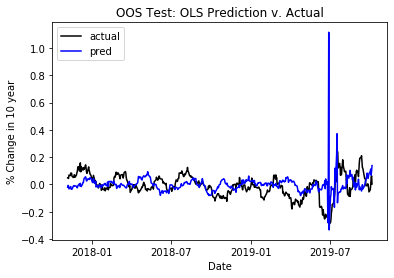

In [136]:
# Create plots of results
fig, ax = plt.subplots()
locator = mdates.AutoDateLocator(minticks=5, maxticks=7)
formatter = mdates.AutoDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(date_test, Y_test, 'k', label='actual')
ax.plot(date_test, pred_OLS, 'b', label='pred')
ax.set_xlabel('Date')
ax.set_ylabel('% Change in 10 year')
ax.legend()
plt.title('OOS Test: OLS Prediction v. Actual')
plt.show()

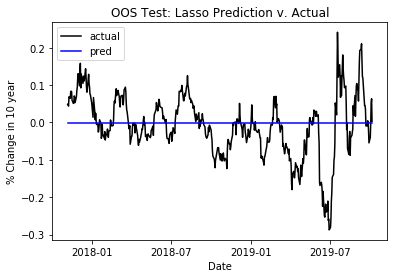

In [137]:
fig, ax = plt.subplots()
locator = mdates.AutoDateLocator(minticks=5, maxticks=7)
formatter = mdates.AutoDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(date_test, Y_test, 'k', label='actual')
ax.plot(date_test, pred_Lasso, 'b', label='pred')
ax.set_xlabel('Date')
ax.set_ylabel('% Change in 10 year')
ax.legend()
plt.title('OOS Test: Lasso Prediction v. Actual')
plt.show()

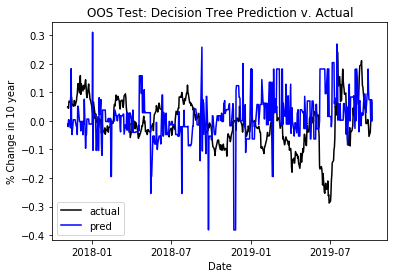

In [138]:
fig, ax = plt.subplots()
locator = mdates.AutoDateLocator(minticks=5, maxticks=7)
formatter = mdates.AutoDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(date_test, Y_test, 'k', label='actual')
ax.plot(date_test, pred_Tree, 'b', label='pred')
ax.set_xlabel('Date')
ax.set_ylabel('% Change in 10 year')
ax.legend()
plt.title('OOS Test: Decision Tree Prediction v. Actual')
plt.show()

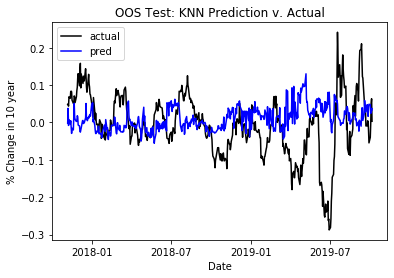

In [139]:
fig, ax = plt.subplots()
locator = mdates.AutoDateLocator(minticks=5, maxticks=7)
formatter = mdates.AutoDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.plot(date_test, Y_test, 'k', label='actual')
ax.plot(date_test, pred_KNN, 'b', label='pred')
ax.set_xlabel('Date')
ax.set_ylabel('% Change in 10 year')
ax.legend()
plt.title('OOS Test: KNN Prediction v. Actual')
plt.show()

As you can see, none of these models are very good. However, this is expected since our variable selection was naive. 

In [140]:
# We can start by narrowing our dataset to only include variables that we believe will be better predictors of rates. 
features = ['Financials', 'Utilities','USGG2YR Index', 'USGG10YR Index', 'GDBR10 Index', 'Dollar Index', 'HG1 Comdty', \
           'LB1 Comdty','CL1 Comdty', 'GC1 Comdty']

In [157]:
X_narrow = select_dataset[features]
X_narrow['HG1 Comdty']

5020   -0.093939
5019    0.006231
5018   -0.051515
5017   -0.140351
5016   -0.093023
5015   -0.186667
5014   -0.289544
5013   -0.224932
5012   -0.192737
5011   -0.247887
5010   -0.321330
5009   -0.230530
5008   -0.390244
5007   -0.338936
5006   -0.374663
5005   -0.408046
5004   -0.523256
5003   -0.442478
5002   -0.444444
5001   -0.337793
5000   -0.434641
4999   -0.408027
4998   -0.448916
4997   -0.501597
4996   -0.448980
4995   -0.445513
4994   -0.403279
4993   -0.328302
4992   -0.500000
4991   -0.460208
          ...   
71      0.018164
70      0.018721
69      0.002723
68      0.008346
67      0.011375
66      0.004315
65      0.016410
64     -0.016182
63     -0.029724
62     -0.020897
61     -0.022269
60     -0.022459
59     -0.000191
58     -0.004545
57     -0.023540
56     -0.008910
55     -0.013899
54     -0.005551
53      0.010930
52      0.015346
51      0.008233
50      0.024938
49      0.021440
48      0.038021
47      0.032916
46      0.043824
45      0.049014
44      0.0262

In [143]:
# I'll create a function to run through the data splitting and model building process.
def model_train_test(test_len, X, Y, dates):
    split = len(X) - test_len
    X_train = X.iloc[:split]
    X_test = X.iloc[split+1:]
    Y_train = Y.iloc[:split]
    Y_test = Y.iloc[split+1:]
    date_train = dates.iloc[:split]
    date_test = dates.iloc[split+1:]
    
    # Model forms
    model1 = LinearRegression()
    model2 = linear_model.Lasso() # default alpha = 1
    model3 = DecisionTreeRegressor(max_depth=20)
    model4 = KNeighborsRegressor(n_neighbors=50, weights='distance')
    
    # Fit models
    model1.fit(X_train,Y_train)
    model2.fit(X_train,Y_train)
    model3.fit(X_train,Y_train)
    model4.fit(X_train,Y_train)
    
    # Predict Y_test
    pred_1 = OLS.predict(X_test)
    pred_2 = Lasso.predict(X_test)
    pred_3 = Tree.predict(X_test)
    pred_4 = KNN.predict(X_test)
    
    RMSE_1 = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_1))
    RMSE_2 = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_2))
    RMSE_3 = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_3))
    RMSE_4 = sqrt(mean_squared_error(y_true = Y_test, y_pred = pred_4))
    return (RMSE_1, RMSE_2, RMSE_3, RMSE_4)

In [154]:
X_narrow.describe()

,Financials,Utilities,USGG2YR Index,USGG10YR Index,GDBR10 Index,Dollar Index,HG1 Comdty,LB1 Comdty,CL1 Comdty,GC1 Comdty
count,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000,4979.000000
mean,0.003029,0.003139,0.006392,-0.001580,0.003301,-0.000404,-inf,-0.000661,-0.001338,0.006138
std,0.065680,0.047472,0.156758,0.083654,1.923487,0.022549,NaN,0.063573,0.059784,0.042339
min,-0.371114,-0.300848,-0.551518,-0.381702,-54.666667,-0.096873,-inf,-0.226477,-0.247210,-0.181584
25%,-0.024568,-0.019506,-0.082000,-0.050048,-0.070959,-0.014248,-0.046996,-0.037593,-0.032217,-0.018979
50%,0.008126,0.009122,-0.000760,-0.006643,-0.018151,-0.000106,0.006032,-0.004898,0.003673,0.005152
75%,0.034936,0.032025,0.076085,0.043759,0.044254,0.013291,0.067064,0.033448,0.033635,0.032057
max,0.579423,0.300595,0.734987,0.358169,89.666667,0.129703,70.000000,0.319677,0.244783,0.171842


In [144]:
(RMSE_1, RMSE_2, RMSE_3, RMSE_4) = model_train_test(500, X_narrow, Y, date)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').